# Exploratory Data Analysis 
## MLB Statistics by Team - Current Season

This notebook documents an Exploratory Data Analysis of the compiled MLB statistics dataset that will be analyzed in an effort to predict game outcomes. This analysis seeks to visualize the data in order to provide key insights in terms of potential predictive features and relationships that can be exploited using machine learning models. 

### Notebook Setup

The following code cell adds the root directory of the project to Python's `sys.path` in order to access modules from different directory levels.

In [63]:
import sys
from pathlib import Path

notebook_module = Path.cwd()
project_root = notebook_module.parent.parent.parent
sys.path.append(str(project_root))

The next code cell allows the notebook to access and load environment variables that are required for configuring the database connection.

In [64]:
from dotenv import load_dotenv

dotenv_path = project_root / 'api/.env'
load_dotenv(dotenv_path)

True

Import the necessary dependencies.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from shared.database import connect_to_db

### Analysis

After connecting to the PostgreSQL database, read each relevant table into a Pandas DataFrame.

In [66]:
session = connect_to_db()

teams_df = pd.read_sql_table('mlb_teams', session.bind)
offensive_stats_df = pd.read_sql_table('mlb_offensive_stats', session.bind)
defensive_stats_df = pd.read_sql_table('mlb_defensive_stats', session.bind)
schedule_df = pd.read_sql_table('mlb_schedule', session.bind)
teams_df.head()

,id,name,division,games_played,wins,losses,winning_percentage
0,147,New York Yankees,American League East,162,94,68,0.580
1,110,Baltimore Orioles,American League East,162,91,71,0.562
2,111,Boston Red Sox,American League East,162,81,81,0.500
3,139,Tampa Bay Rays,American League East,162,80,82,0.494
4,141,Toronto Blue Jays,American League East,162,74,88,0.457


In [67]:
teams_df.drop(columns=['id', 'games_played']).describe()

,wins,losses,winning_percentage
count,30.000000,30.000000,30.000000
mean,80.966667,80.966667,0.499967
std,12.469226,12.521659,0.077075
min,41.000000,64.000000,0.253000
25%,76.250000,73.000000,0.470500
50%,83.000000,79.000000,0.512000
75%,89.000000,85.750000,0.549000
max,98.000000,121.000000,0.605000


<Figure size 1500x1000 with 0 Axes>

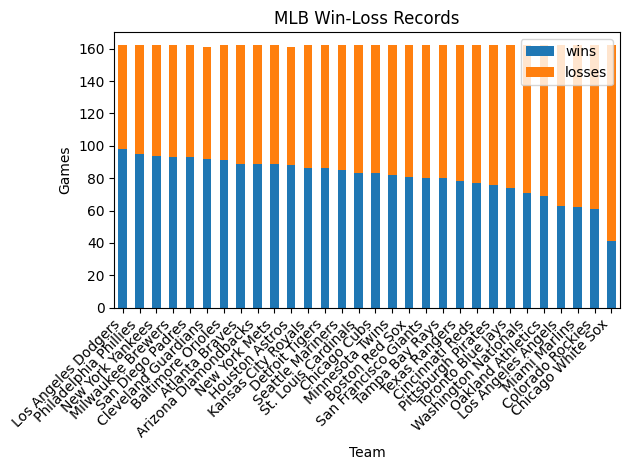

In [88]:
plt.figure(figsize=(15, 10))
teams_df.sort_values('winning_percentage', ascending=False).plot(x='name', y=['wins', 'losses'], kind='bar', stacked=True)
plt.title('MLB Win-Loss Records')
plt.xlabel('Team')
plt.ylabel('Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Summary of Home/Away Performance:
Average Home Wins per Team: 44.0
Average Away Wins per Team: 40.4

Teams with Largest Home/Away Splits:

Biggest Home Advantage: Philadelphia Phillies
Home: 56 wins, Away: 41 wins
Difference: 15 more wins at home

Biggest Road Advantage: New York Yankees
Home: 48 wins, Away: 53 wins
Difference: 5 more wins on the road


<Figure size 1200x600 with 0 Axes>

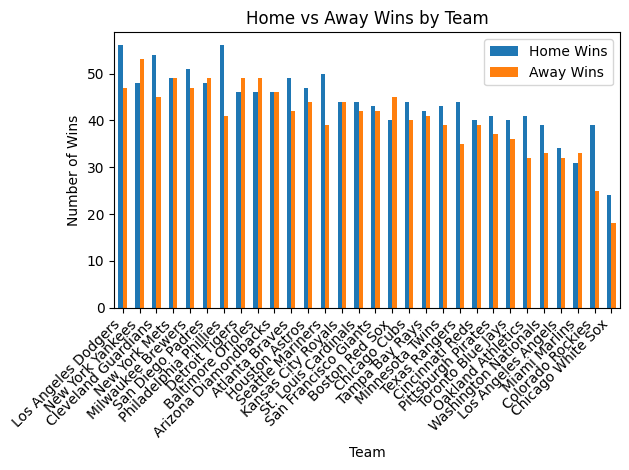

In [94]:
# Home vs Away Performance Analysis

# Filter for completed games and make a copy
completed_games = schedule_df[schedule_df['status'] == 'Final'].copy()

# Calculate home and away wins using .loc
completed_games.loc[:, 'home_team_win'] = completed_games['home_score'] > completed_games['away_score']
completed_games.loc[:, 'away_team_win'] = completed_games['away_score'] > completed_games['home_score']

# Calculate wins for home teams
home_wins = completed_games.groupby('home_team_id').agg({
    'home_team_win': 'sum',
    'home_score': 'count'
}).reset_index()
home_wins.columns = ['team_id', 'home_wins', 'home_games']

# Calculate wins for away teams
away_wins = completed_games.groupby('away_team_id').agg({
    'away_team_win': 'sum',
    'away_score': 'count'
}).reset_index()
away_wins.columns = ['team_id', 'away_wins', 'away_games']

# Merge the data
performance = pd.merge(home_wins, away_wins, on='team_id')
performance = pd.merge(teams_df[['id', 'name']], performance, 
                      left_on='id', right_on='team_id')

# Sort by total wins for better visualization
performance['total_wins'] = performance['home_wins'] + performance['away_wins']
performance = performance.sort_values('total_wins', ascending=False)

plt.figure(figsize=(12, 6))
ax = performance.plot(x='name', y=['home_wins', 'away_wins'], kind='bar')
plt.title('Home vs Away Wins by Team')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45, ha='right')
plt.legend(['Home Wins', 'Away Wins'])
plt.tight_layout()

print("\nSummary of Home/Away Performance:")
print(f"Average Home Wins per Team: {performance['home_wins'].mean():.1f}")
print(f"Average Away Wins per Team: {performance['away_wins'].mean():.1f}")

print("\nTeams with Largest Home/Away Splits:")
performance['win_difference'] = performance['home_wins'] - performance['away_wins']
best_home_team = performance.loc[performance['win_difference'].idxmax()]
worst_home_team = performance.loc[performance['win_difference'].idxmin()]

print(f"\nBiggest Home Advantage: {best_home_team['name']}")
print(f"Home: {int(best_home_team['home_wins'])} wins, Away: {int(best_home_team['away_wins'])} wins")
print(f"Difference: {int(best_home_team['win_difference'])} more wins at home")

print(f"\nBiggest Road Advantage: {worst_home_team['name']}")
print(f"Home: {int(worst_home_team['home_wins'])} wins, Away: {int(worst_home_team['away_wins'])} wins")
print(f"Difference: {abs(int(worst_home_team['win_difference']))} more wins on the road")

In [68]:
recent_offensive_stats = offensive_stats_df.sort_values('date').groupby('team_id').last().reset_index()
merged_offensive = pd.merge(teams_df, recent_offensive_stats, left_on='id', right_on='team_id')

merged_offensive.head()

,id_x,name,division,games_played,wins,losses,winning_percentage,team_id,id_y,date,team_batting_average,runs_scored,home_runs,on_base_percentage,slugging_percentage
0,147,New York Yankees,American League East,162,94,68,0.580,147,226,2024-10-15,0.248,815,237,0.333,0.429
1,110,Baltimore Orioles,American League East,162,91,71,0.562,110,227,2024-10-15,0.250,786,235,0.315,0.435
2,111,Boston Red Sox,American League East,162,81,81,0.500,111,228,2024-10-15,0.252,751,194,0.319,0.423
3,139,Tampa Bay Rays,American League East,162,80,82,0.494,139,229,2024-10-15,0.230,604,147,0.302,0.366
4,141,Toronto Blue Jays,American League East,162,74,88,0.457,141,230,2024-10-15,0.241,671,156,0.313,0.389


Next, we will examine the relationships between a team's total number of wins and their batting average, as well as on-base percentage.

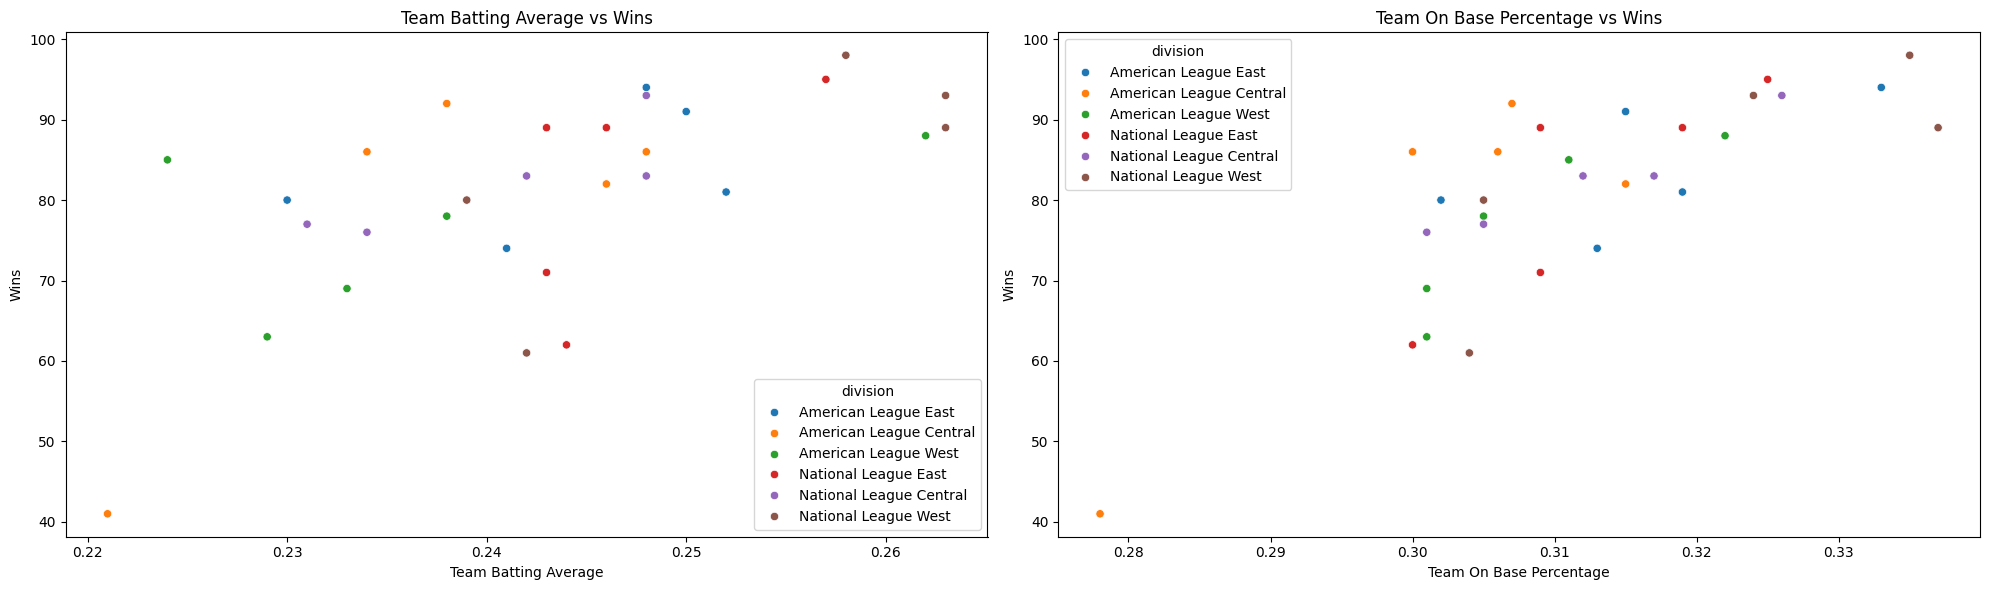

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(data=merged_offensive, x='team_batting_average', y='wins', hue='division', ax=axes[0])
axes[0].set_title('Team Batting Average vs Wins')
axes[0].set_xlabel('Team Batting Average')
axes[0].set_ylabel('Wins')

sns.scatterplot(data=merged_offensive, x='on_base_percentage', y='wins', hue='division', ax=axes[1])
axes[1].set_title('Team On Base Percentage vs Wins')
axes[1].set_xlabel('Team On Base Percentage')
axes[1].set_ylabel('Wins')

plt.tight_layout()
plt.show()

In [70]:
recent_defensive_stats = defensive_stats_df.sort_values('date').groupby('team_id').last().reset_index()
merged_defensive = pd.merge(teams_df, recent_defensive_stats, left_on='id', right_on='team_id')
merged_defensive.head()

,id_x,name,division,games_played,wins,losses,winning_percentage,team_id,id_y,date,team_era,runs_allowed,whip,strikeouts,avg_against
0,147,New York Yankees,American League East,162,94,68,0.580,147,226,2024-10-15,3.74,668,1.24,1457,0.233
1,110,Baltimore Orioles,American League East,162,91,71,0.562,110,227,2024-10-15,3.94,699,1.24,1380,0.238
2,111,Boston Red Sox,American League East,162,81,81,0.500,111,228,2024-10-15,4.04,747,1.26,1353,0.246
3,139,Tampa Bay Rays,American League East,162,80,82,0.494,139,229,2024-10-15,3.77,663,1.20,1406,0.236
4,141,Toronto Blue Jays,American League East,162,74,88,0.457,141,230,2024-10-15,4.29,743,1.27,1314,0.243


Simlarly, let's see how a team's ERA and their opponents' batting averages affect their performance, in terms of total number of wins. 

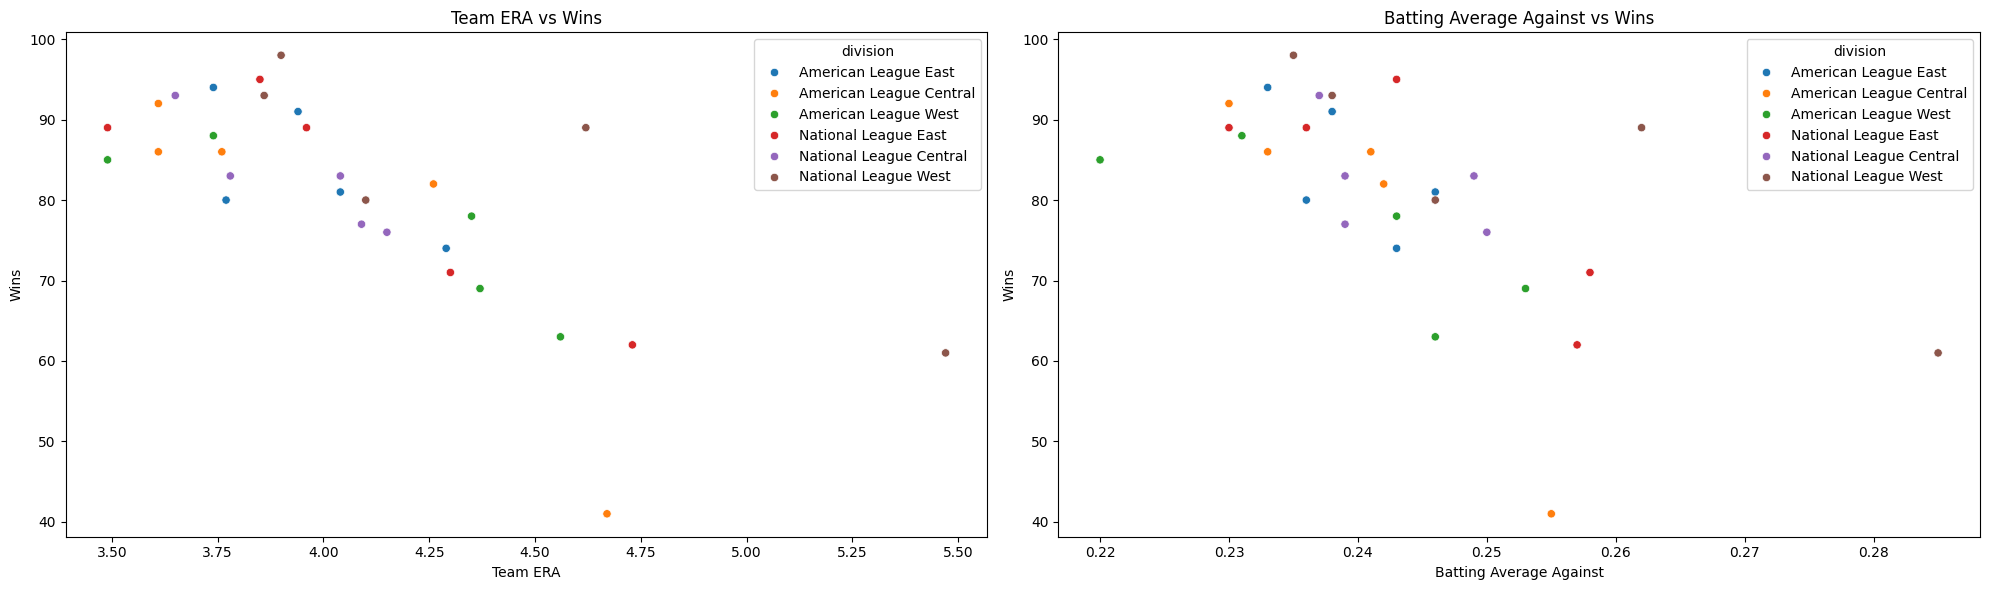

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(data=merged_defensive, x='team_era', y='wins', hue='division', ax=axes[0])
axes[0].set_title('Team ERA vs Wins')
axes[0].set_xlabel('Team ERA')
axes[0].set_ylabel('Wins')

sns.scatterplot(data=merged_defensive, x='avg_against', y='wins', hue='division', ax=axes[1])
axes[1].set_title('Batting Average Against vs Wins')
axes[1].set_xlabel('Batting Average Against')
axes[1].set_ylabel('Wins')

plt.tight_layout()
plt.show()

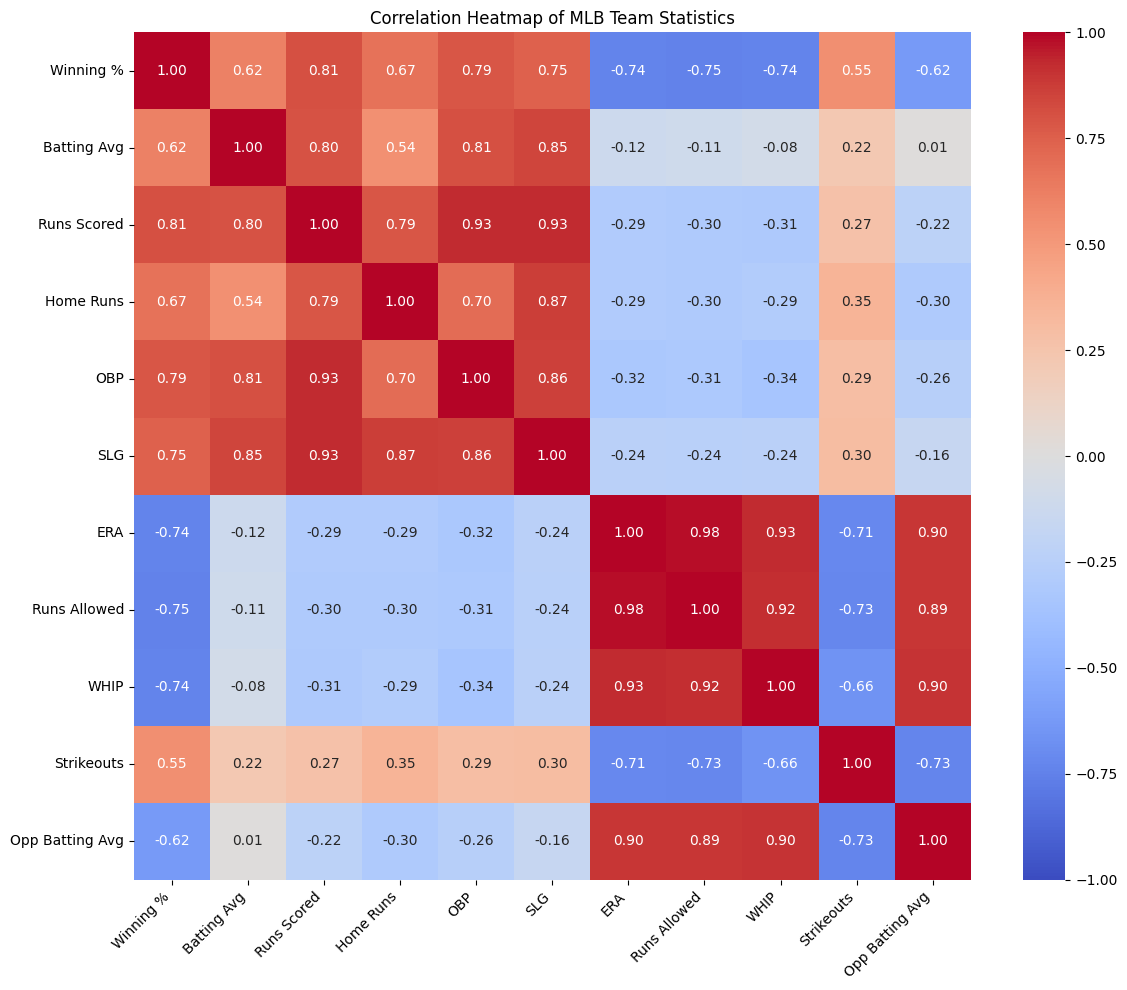


Summary statistics for key metrics:
       Winning %  Batting Avg  Runs Scored  Home Runs     OBP     SLG     ERA  \
count     30.000       30.000       30.000     30.000  30.000  30.000  30.000   
mean       0.500        0.243      711.433    181.767   0.312   0.399   4.073   
std        0.077        0.011       75.465     26.940   0.013   0.025   0.436   
min        0.253        0.221      507.000    133.000   0.278   0.340   3.490   
25%        0.470        0.235      671.250    165.000   0.304   0.381   3.762   
50%        0.512        0.243      701.500    178.000   0.310   0.396   4.000   
75%        0.549        0.248      757.750    195.500   0.319   0.417   4.297   
max        0.605        0.263      886.000    237.000   0.337   0.446   5.470   

       Runs Allowed    WHIP  Strikeouts  Opp Batting Avg  
count        30.000  30.000      30.000           30.000  
mean        711.433   1.270    1373.233            0.243  
std          73.495   0.084      84.024            0.012

In [89]:
merged_stats = pd.merge(
    merged_offensive,
    merged_defensive,
    on=['team_id'],
    suffixes=('_offensive', '_defensive')
)

# Since winning_percentage is the same in both offensive and defensive stats
# (they're from the same team), we can use either one
stats_columns = [
    'winning_percentage_offensive',
    'team_batting_average',
    'runs_scored',
    'home_runs',
    'on_base_percentage',
    'slugging_percentage',
    'team_era',
    'runs_allowed',
    'whip',
    'strikeouts',
    'avg_against'
]

# Verify columns exist
existing_columns = [col for col in stats_columns if col in merged_stats.columns]
missing_columns = [col for col in stats_columns if col not in merged_stats.columns]

if missing_columns:
    print("\nWarning: The following columns are missing from the merged DataFrame:")
    print(missing_columns)
    stats_columns = existing_columns

# Create correlation matrix
correlation_matrix = merged_stats[stats_columns].corr()

# Rename the correlation matrix index/columns for better readability
prettier_names = {
    'winning_percentage_offensive': 'Winning %',
    'team_batting_average': 'Batting Avg',
    'runs_scored': 'Runs Scored',
    'home_runs': 'Home Runs',
    'on_base_percentage': 'OBP',
    'slugging_percentage': 'SLG',
    'team_era': 'ERA',
    'runs_allowed': 'Runs Allowed',
    'whip': 'WHIP',
    'strikeouts': 'Strikeouts',
    'avg_against': 'Opp Batting Avg'
}

correlation_matrix.index = [prettier_names.get(col, col) for col in correlation_matrix.index]
correlation_matrix.columns = [prettier_names.get(col, col) for col in correlation_matrix.columns]

# Visualize correlation matrix with improved labels
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0,
            fmt='.2f')  
plt.title('Correlation Heatmap of MLB Team Statistics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nSummary statistics for key metrics:")
summary_stats = merged_stats[stats_columns].describe()
summary_stats.columns = [prettier_names.get(col, col) for col in summary_stats.columns]
print(summary_stats.round(3))